In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import jit, grad, jacfwd, jacrev

In [2]:
Q = np.diag([1.0, 1.0])

# Only for contour plot
def plot_f(X, Y):
    # equivalent to 0.5 * ([X,Y] - [1,0]).T @ Q @ ([X,Y] - [1,0])
    return 0.5*(0.5*(X-1)**2 + Y**2)

def f(x):
    B = np.array([1, 0])
    return 0.5 * (x - B).T @ Q @ (x - B)

def grad_f(x):
    B = np.array([1, 0])
    return Q @ (x - B)

def hess_f(x):
    return Q

In [3]:
def c(x):
    return x[0]**2 + 2*x[0] - x[1]

# Caution, output of ∂c should be a vector for gradient calculation 
def partial_c(x):
    return np.array([[2 * x[0] + 2, -1]])

def partial_c_jnp(x):
    return jnp.array([2 * x[0] + 2, -1])

## Visualization

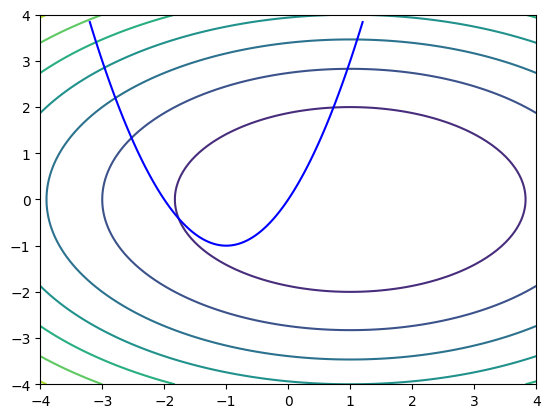

In [5]:
def plot_landscape():

    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = plot_f(X, Y)
    contour = plt.contour(X, Y, Z)
    
    xc = np.linspace(-3.2, 1.2, 100)
    plt.plot(xc, xc**2 + 2.0*xc, color='blue')
    
plot_landscape()
plt.show()

## Newton's Method

In [6]:
@jit
def KKT_hessian(x, λ0):
    return jnp.array(grad_f(x)) + jnp.array(partial_c_jnp(x)) * λ0

In [7]:
def newton_step(x0, λ0, verbose=False):
    
    C = partial_c(x0)
    
    d_xL = grad_f(x0) + C * λ0
    d_λL = c(x0)

    h_xL, _ = jacrev(KKT_hessian, argnums=(0,1))(jnp.array(x0), jnp.array(λ0))

    KKT_lhs = np.block([ [h_xL, C.T], [C, np.zeros((1,1))] ]) 
    KKT_rhs = np.block([ -d_xL, np.array([[-c(x0)]]) ]).T
    
    d_z = np.linalg.inv(KKT_lhs).dot(KKT_rhs)
    d_x = d_z[0:2].flatten().tolist()
    d_λ = d_z[2].flatten().tolist()

    return x0 + d_x, λ0 + d_λ

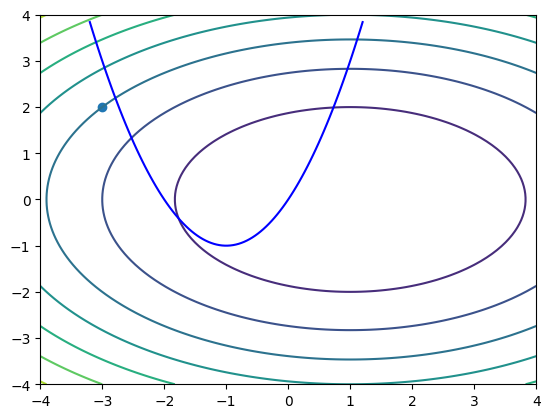

In [8]:
x_guess = np.array([[-3.0, 2.0]])
λ_guess = np.array([[0.0]])
ρ = 1.0
plot_landscape()
plt.scatter(x_guess[0][0], x_guess[0][1])
plt.show()

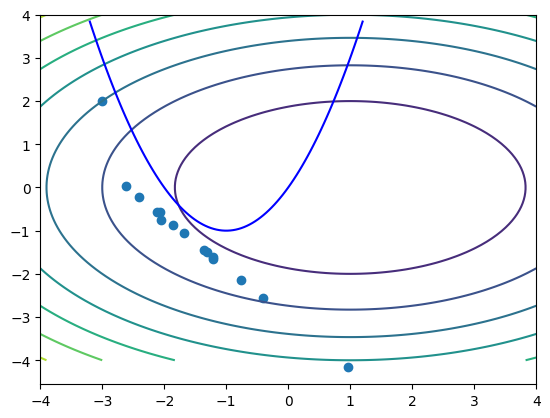

In [27]:
newx, newλ = newton_step(x_guess[-1], λ_guess[-1])
x_guess = np.append(x_guess, [newx], axis=0)
λ_guess = np.append(λ_guess, [newλ], axis=0)

plot_landscape()
plt.scatter(x_guess[:,0], x_guess[:,1])
plt.show()

### Let's Check Hessian of L

In [28]:
Hessian_end, _ = jacrev(KKT_hessian, argnums=(0,1))(x_guess[-1], λ_guess[-1])
C = partial_c(x_guess[-1])
H = np.block([ [Hessian_end, C.T], [C, np.zeros((1,1))] ]) 

np.linalg.eigvals(H)

array([-3.33850545, -0.5589424 ,  1.63083151])

## Regularized Newton Step

In [42]:
def regularized_newton_step(x0, λ):

    Β = 1.0
    C = partial_c(x0)
    d_xL = grad_f(x0) + C * λ0
    h_xL, _ = jacrev(KKT_hessian, argnums=(0,1))(jnp.array(x0), jnp.array(λ0))

    H = np.block([ [h_xL, C.T], [C, np.zeros((1,1))] ]) 
    e = np.linalg.eigvals(H)

    while not(np.sum(e>0) == len(x0) and np.sum(e<0) == len(λ)):
        # H = H + Β * Diagonal([Β*ones(length(x0)); -Β*ones(length(λ))])
        H += B * np.diag([1.0]*len(x0) + [1.0]*len(λ))
        e = np.linalg.eigvals(H)

    KKT_rhs = np.block([ -d_xL, np.array([[-c(x0)]]) ]).T
    d_z = np.linalg.inv(H).dot(KKT_rhs)
    d_x = d_z[0:2].flatten().tolist()
    d_λ = d_z[2].flatten().tolist()

    return x0 + d_x, λ0 + d_λ

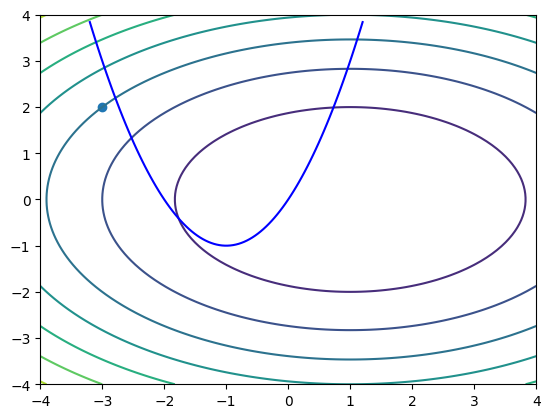

In [44]:
x_guess = np.array([[-3.0, 2.0]])
λ_guess = np.array([[0.0]])
ρ = 1.0
plot_landscape()
plt.scatter(x_guess[0][0], x_guess[0][1])
plt.show()

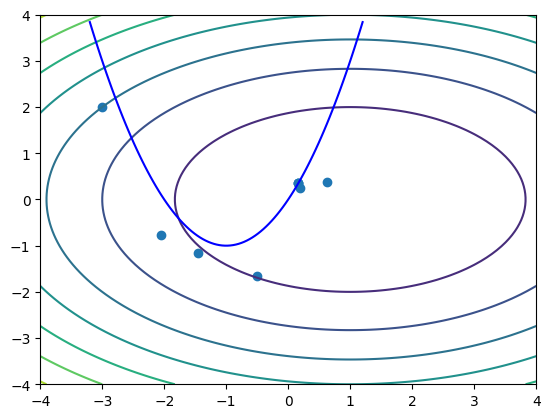

In [52]:
newx, newλ = regularized_newton_step(x_guess[-1], λ_guess[-1])
x_guess = np.append(x_guess, [newx], axis=0)
λ_guess = np.append(λ_guess, [newλ], axis=0)

plot_landscape()
plt.scatter(x_guess[:,0], x_guess[:,1])
plt.show()

### Let's Check Hessian of L

In [53]:
Hessian_end, _ = jacrev(KKT_hessian, argnums=(0,1))(x_guess[-1], λ_guess[-1])
C = partial_c(x_guess[-1])
H = np.block([ [Hessian_end, C.T], [C, np.zeros((1,1))] ]) 

np.linalg.eigvals(H)

array([-1.86560582,  3.48089984,  1.10071464])